#Q4  MLA && PCA - Traffic Density -> Traffic Duration / Traffic Clustering - GET DATA HOURLY

## MULTITHREADING CODE

In [5]:
import os
import requests
import pandas as pd
from datetime import datetime, timedelta
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor

# Define the start and end dates
start_date = datetime.strptime('20230901', '%Y%m%d')
end_date = datetime.strptime('20230902', '%Y%m%d')

# Define the base URL
base_url = 'https://api.data.gov.hk/v1/historical-archive/get-file?url=https%3A%2F%2Fresource.data.one.gov.hk%2Ftd%2Ftraffic-detectors%2FrawSpeedVol-all.xml&time='

# Function to fetch data for a given minute
def fetch_data(minute, current_date, hour, totals):
    # Generate the timestamp for the current minute
    timestamp = current_date.strftime('%Y%m%d') + '-' + f'{hour:02d}{minute:02d}'

    # Fetch the data for the current timestamp
    response = requests.get(base_url + timestamp)

    # Check the status of the response
    if response.status_code != 200:
        print(f"Failed to fetch data for {timestamp}, status code: {response.status_code}")
        return

    root = ET.fromstring(response.content)

    # Extract the data and add it to the dictionary
    for period in root.findall('.//periods/period'):
        for detector in period.findall('.//detectors/detector'):
            detector_id = detector.find('detector_id').text

            for lane in detector.findall('.//lanes/lane'):
                lane_id_element = lane.find('lane_id')
                if lane_id_element is not None:
                    lane_id = lane_id_element.text
                else:
                    print("lane_id element not found")
                    continue

                speed_element = lane.find('speed')

                occupancy = int(lane.find('occupancy').text)
                volume = int(lane.find('volume').text)

                # Check if the 'speed' element is present and contains a valid float
                if speed_element is not None:
                    try:
                        speed = float(speed_element.text)
                    except ValueError:
                        print(f"Invalid speed: {speed_element.text}")
                        continue

                    # Add the speed to the total for the current detector and lane id
                    if (detector_id, lane_id) not in totals:
                        totals[(detector_id, lane_id)] = [speed, 1, occupancy, volume]
                    else:
                        totals[(detector_id, lane_id)][0] += speed
                        totals[(detector_id, lane_id)][1] += 1
                        totals[(detector_id, lane_id)][2] += occupancy
                        totals[(detector_id, lane_id)][3] += volume

# Loop over the date range
current_date = start_date
while current_date <= end_date:
    # Loop over each hour of the current day
    for hour in range(0, 24):
        # Save the DataFrame to a CSV file
        filename = f"traffic_{current_date.strftime('%Y%m%d')}_hour_{hour}.csv"
        
        print('Getting', filename);

        if os.path.isfile(filename):
            print(f"File {filename} already exists. Skipping this hour.")
            continue

        # Initialize a dictionary to store the total speed and count for each detector and lane
        totals = {}

        # Create a ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=10) as executor:
            # Loop over each minute of the current hour
            for minute in range(0, 60):
                executor.submit(fetch_data, minute, current_date, hour, totals)

        # Calculate the average speed for each detector and lane id and add it to the list
        data = [{'detectorID': detector_id, 'laneType': lane_id, 'speed': total_speed / count, 'totalOccupancy': total_occupancy, 'totalVolume': total_volume}
                for (detector_id, lane_id), (total_speed, count, total_occupancy, total_volume) in totals.items()]

        # Convert the list into a DataFrame
        df = pd.DataFrame(data)

        # Save the DataFrame to a CSV file
        df.to_csv(filename, index=False)
        print(f"File {filename} saved.")

        print(f"end of the hour {hour}")
    # Move to the next day
    current_date += timedelta(days=1)

print(f"finished fetch")


Getting traffic_20230901_hour_0.csv
File traffic_20230901_hour_0.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_1.csv
File traffic_20230901_hour_1.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_2.csv
File traffic_20230901_hour_2.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_3.csv
File traffic_20230901_hour_3.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_4.csv
File traffic_20230901_hour_4.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_5.csv
File traffic_20230901_hour_5.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_6.csv
File traffic_20230901_hour_6.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_7.csv
File traffic_20230901_hour_7.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_8.csv
File traffic_20230901_hour_8.csv already exists. Skipping this hour.
Getting traffic_20230901_hour_9.csv
File traffic_202309

#Append Geographic info to the dataset

In [6]:
import pandas as pd
import os

# Define the path to the location data and load it into a DataFrame
location_data_path = "./traffic_speed_volume_occ_info.csv"
location_data = pd.read_csv(location_data_path)

# Define the path to the data folder
data_folder_path = "."

# Define the path to the output directory and create it if it does not exist
output_directory_path = "./geoMod"
os.makedirs(output_directory_path, exist_ok=True)

# Iterate over the specified range of dates
for date in range(20230901, 20230905):
    # Iterate over all the hours in a day
    for hour in range(24):
        # Define the path to the current file
        file_path = os.path.join(data_folder_path, f"traffic_{date}_hour_{str(hour)}.csv")
        
        # Check if the file exists
        if os.path.exists(file_path):
            # Load the current file into a DataFrame
            data = pd.read_csv(file_path)
            
            # Merge the data with the location data
            merged_data = pd.merge(data, location_data, how="left", left_on="detectorID", right_on="AID_ID_Number")

            
            # Keep only the necessary columns
            merged_data = merged_data[["detectorID", "laneType", "speed", "totalOccupancy", "totalVolume", "Latitude", "Longitude", "District" , "Road_EN"]]
            
            # Define the path to the output file
            output_file_path = os.path.join(output_directory_path, f"traffic_{date}_hour_{str(hour)}.csv")

            print(merged_data);
            
            # Save the merged data to the output file
            merged_data.to_csv(output_file_path, index=False)

       detectorID     laneType      speed  totalOccupancy  totalVolume  \
0        AID01101    Fast Lane  68.683333             266           89   
1        AID01101  Middle Lane  64.266667             647          186   
2        AID01101    Slow Lane  61.908333             271           68   
3        AID01102    Fast Lane  74.950000             142           67   
4        AID01102  Middle Lane  71.308333             774          246   
...           ...          ...        ...             ...          ...   
1842  TDSYSR20001    Slow Lane  63.841667             229          104   
1843  TDSYSR20002    Fast Lane  74.900000             263          162   
1844  TDSYSR20002    Slow Lane  76.300000             210          119   
1845  TDSYSR20003    Fast Lane  61.916667             229          125   
1846  TDSYSR20003    Slow Lane  63.650000             183           84   

       Latitude   Longitude  District  \
0     22.248091  114.152525  Southern   
1     22.248091  114.152525  

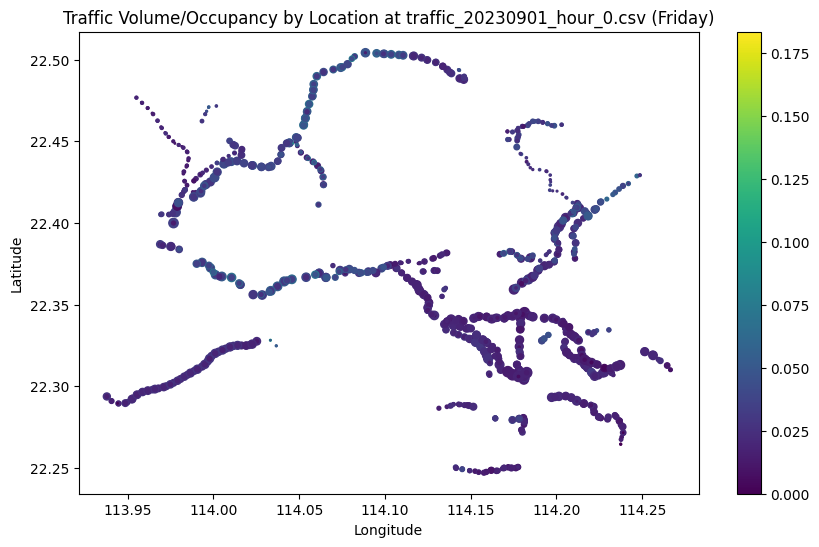

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

path = './geoMod/traffic_20230901_hour_0.csv';

df = pd.read_csv('./geoMod/traffic_20230901_hour_0.csv')

dataDt = path.split('/')[-1];

# Extract the date from the filename
date_str = dataDt.split('_')[1]

# Convert the date string to a datetime object
date = datetime.strptime(date_str, '%Y%m%d')

# Get the day of the week
day_of_week = date.strftime('%A')

# Create a new column for the ratio of totalVolume to totalOccupancy
df['Volume/Occupancy'] = df['totalVolume'] / df['totalOccupancy']

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Volume/Occupancy'] /20, s=df['totalVolume']/20)
plt.colorbar(scatter)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Traffic Volume/Occupancy by Location at {dataDt} ({day_of_week})')
plt.show()


# Show the MAP OF HONG KONG

In [8]:
import folium

# Create a map centered around Hong Kong
m = folium.Map(location=[22.3193, 114.1694], zoom_start=11, min_zoom=11)

# Add the traffic data as circle markers to the map
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=row['totalVolume'] / 200,  # scale the radius as needed
        color=plt.cm.viridis(row['Volume/Occupancy']),  # use the same colormap as the scatter plot
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Display the map
m


#Show the Traffic Graph at various Time From Fri sep1 to Mon sep4

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os
from glob import glob

# Path to the csv files
path = './geoMod/'

# Get a list of all csv files in the directory
files = glob(os.path.join(path, '*.csv'))

# # Sort the files by the date and hour in the file name
files.sort(key=lambda x: (x.split('/')[-1].split('_')[1], int(x.split('/')[-1].split('_')[3].split('.')[0])))

# Create a list to store the images
images = []

# Loop through all the files
for file in files:
    # Load the csv file into a DataFrame
    df = pd.read_csv(file)

    dataDt = file.split('/')[-1];

    # Extract the date from the filename
    date_str = dataDt.split('_')[1]

    # Convert the date string to a datetime object
    date = datetime.strptime(date_str, '%Y%m%d')

    # Get the day of the week
    day_of_week = date.strftime('%A')
    
    # Create a new column for the ratio of totalVolume to totalOccupancy
    df['Volume/Occupancy'] = df['totalVolume'] / df['totalOccupancy']
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Volume/Occupancy']/20, s=df['totalVolume']/20, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Traffic Volume/Occupancy by Location at {file.split("/")[-1]} {day_of_week}')
    
    # Save the plot to a file
    plt.savefig('temp.png')
    plt.close()
    
    # Open the file and add it to the images list
    images.append(imageio.imread('temp.png'))

# Create a gif from the images
imageio.mimsave('./traffic.gif', images, fps=2)

# Delete the temporary image file
os.remove('temp.png')



C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\3858303323.py:51: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\3858303323.py:51: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\3858303323.py:51: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel

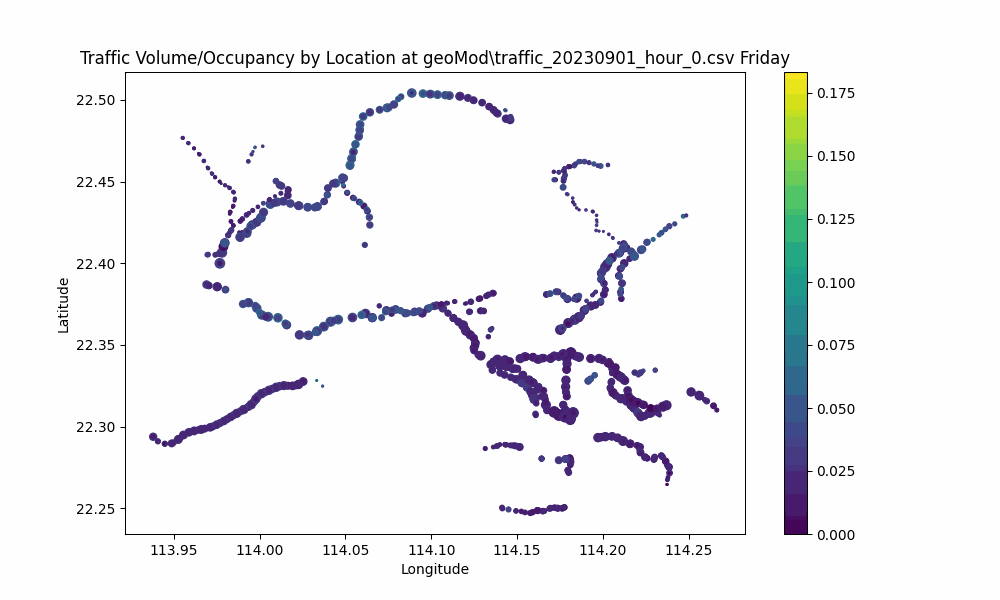

In [10]:
from IPython.display import Image
Image(filename='./traffic.gif') 

#PCA Part- 1

Hong Kong can  be divided into  Districts (Southen/ Yuen Long / Wan Chai). No only can we studying a map, but also can approximate by Tying the first principal component of the location (latitude and longitude).

In [11]:
from sklearn.decomposition import PCA
import pandas as pd

# Assuming the data is stored in a DataFrame named 'data'
data = pd.read_csv('./geoMod/traffic_20230901_hour_8.csv')

# Select the features to include in the PCA
features = data[['speed', 'totalOccupancy', 'totalVolume', 'Longitude', 'Latitude']]

# Create a PCA object
pca = PCA(n_components=1)

# Fit the PCA model to the data
pca.fit(features)

# Transform the data to the first principal component
data['PCAregion'] = pca.transform(features)

# Print the DataFrame with the new 'region' column
# print(data)

print(pca.transform(features))


[[ -73.80072536]
 [ 200.0131456 ]
 [-114.29226007]
 ...
 [ -98.66661857]
 [-275.20887927]
 [-273.25661066]]


##Clustering - Note

The clusters could represent different traffic conditions. For example, one cluster might represent roads with high occupancy and volume (indicating heavy traffic), another cluster might represent roads with low occupancy and volume (indicating light traffic), and the third cluster might represent roads with medium occupancy and volume (indicating moderate traffic). The road name and district information can provide further context about where these traffic conditions are occurring.

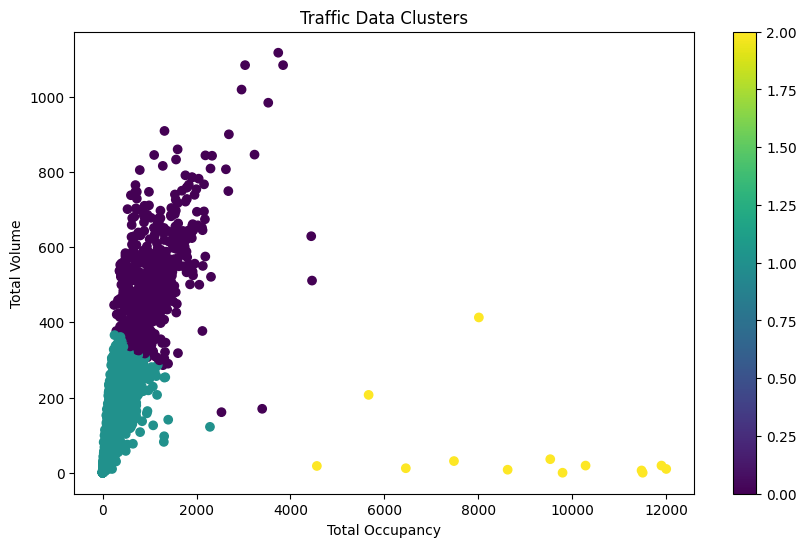

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('./geoMod/traffic_20230901_hour_0.csv')

# Select features for clustering
clustering_features = data[['speed', 'totalOccupancy', 'totalVolume']]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster data to the original DataFrame for better understanding
data['Cluster'] = clusters

# Plotting the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['totalOccupancy'], data['totalVolume'], c=data['Cluster'], cmap='viridis')
plt.title('Traffic Data Clusters')
plt.xlabel('Total Occupancy')
plt.ylabel('Total Volume')
plt.colorbar(scatter)
plt.show()




In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# Load your data
data = pd.read_csv('./geoMod/traffic_20230901_hour_9.csv')

# Select features for clustering
clustering_features = data[['speed', 'totalOccupancy', 'totalVolume']]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster data to the original DataFrame for better understanding
data['Cluster'] = clusters

# Plotting the clusters using Plotly
fig = px.scatter(data, x='totalOccupancy', y='totalVolume', color='Cluster', title='Traffic Data Clusters', hover_data=['Road_EN', 'District'])
fig.show()


#Cluestering All other Times

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import glob
import imageio

# Get a list of all CSV files in the folder
file_list = glob.glob('./geoMod/*.csv')
# # Sort the files by the date and hour in the file name
file_list.sort(key=lambda x: (x.split('/')[-1].split('_')[1], int(x.split('/')[-1].split('_')[3].split('.')[0])))

images = []
norm = Normalize(vmin=0, vmax=2)  # Normalize the color scale based on the number of clusters

for idx, file_name in enumerate(file_list):
    # Load the data
    data = pd.read_csv(file_name)

    # Select features for clustering
    clustering_features = data[['speed', 'totalOccupancy', 'totalVolume']]
    # clustering_features = data[['speed', 'totalOccupancy', 'totalVolume', 'Longitude', 'Latitude']]

    # Scale the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(clustering_features)

    # Apply K-Means Clustering
    kmeans = KMeans(n_clusters=3, random_state=0)
    clusters = kmeans.fit_predict(features_scaled)

    # Adding the cluster data to the original DataFrame for better understanding
    data['Cluster'] = clusters

    # Plotting the clusters
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data['totalOccupancy'], data['totalVolume'], c=data['Cluster'], cmap='viridis', norm=norm)
    plt.title('Traffic Data Clusters for ' + file_name)
    plt.xlabel('Total Occupancy')
    plt.ylabel('Total Volume')
    
    plt.savefig('temp.png')
    plt.close()
    # Open the file and add it to the images list
    images.append(imageio.imread('temp.png'))

# Save the images as an animated GIF
imageio.mimsave('clusters_animation.gif', images, fps=2)


C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\1997508328.py:46: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\1997508328.py:46: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\1997508328.py:46: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

C:\Users\s0614\AppData\Local\Temp\ipykernel

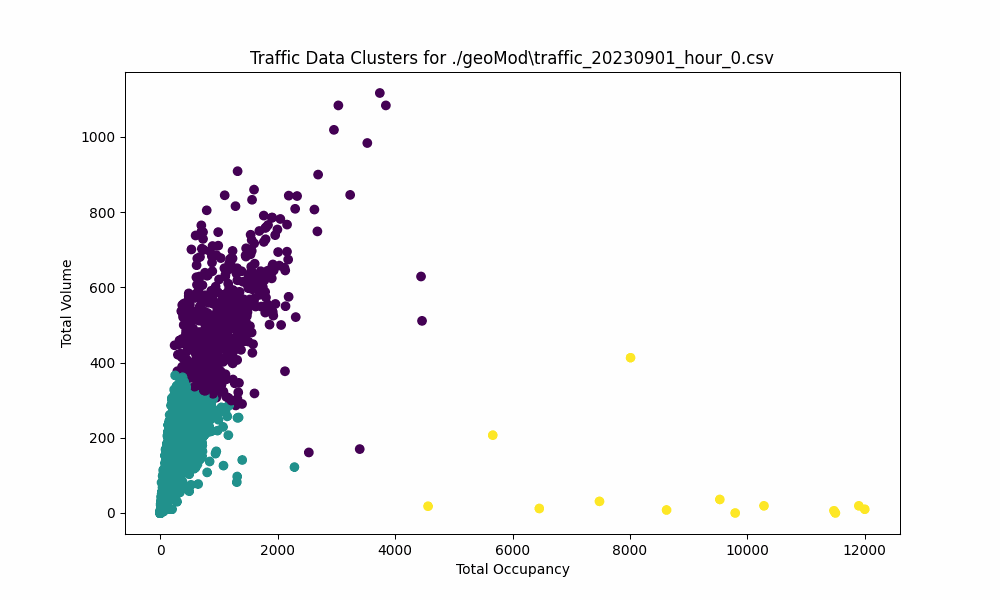

In [18]:

Image(filename='clusters_animation.gif')

## Apply the Cluestering info to HK graph -> To Visualize the Traffic condition

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from datetime import datetime

# Load your data
data = pd.read_csv('./geoMod/traffic_20230901_hour_9.csv')

# Extract the date from the filename
date_str = '20230901'
date = datetime.strptime(date_str, '%Y%m%d')
day_of_week = date.strftime('%A')

# Select features for clustering
clustering_features = data[['speed', 'totalOccupancy', 'totalVolume']]

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(features_scaled)

# Adding the cluster data to the original DataFrame for better understanding
data['Cluster'] = clusters

# Create a new column for the ratio of totalVolume to totalOccupancy
data['Volume/Occupancy'] = data['totalVolume'] / data['totalOccupancy']
# Fill NaN values in 'Volume/Occupancy' column with 0
data['Volume/Occupancy'].fillna(0, inplace=True)

# Plotting the clusters using Plotly
fig = px.scatter_geo(data, lat='Latitude', lon='Longitude', color='Cluster', size='Volume/Occupancy', 
                     hover_data=['Road_EN', 'District'], title=f'Traffic Volume/Occupancy by Location at {date_str} {day_of_week}')
fig.update_geos(showcountries=False, showcoastlines=True, showland=True, fitbounds="locations")
fig.show()


C:\Users\s0614\AppData\Local\Temp\ipykernel_23176\1678979368.py:32: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



